In [1]:
using Revise, Statistics, Distributions, LaTeXStrings
using Formatting
using CairoMakie
using ColorSchemes
import ColorSchemes: nord, tab10, Dark2_8

printx(x,N) = sprintf1("%10.$(N)f",x)

set_theme!(Theme(
    fontsize = 20,
    palette = ( color = Dark2_8,),
    Axis = (
        backgroundcolor = :transparent,
        xtickcolor = nord[5], ytickcolor = nord[5],
        xgridcolor = nord[3], ygridcolor = nord[3],
        xlabelcolor = nord[5], ylabelcolor = nord[5],
        xticklabelcolor = nord[5], yticklabelcolor = nord[5],
        topspinecolor = nord[5], bottomspinecolor = nord[5],
        leftspinecolor = nord[5], rightspinecolor = nord[5],
        titlecolor = nord[5],
    ),
    Legend = (
        bgcolor = :transparent,
        labelcolor = nord[5], titlecolor = nord[5],
        framevisible = false, margin=(0,0,0,0)
    )
))

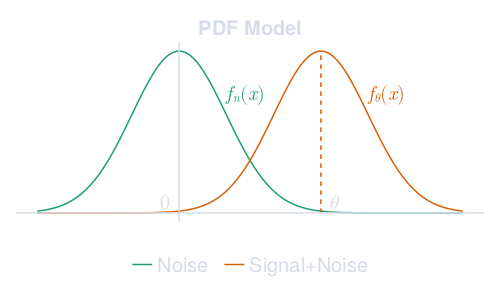

In [2]:
θ = 15; σ = 5;
xs = range(-15,30,200)
fn = Normal(0, σ)
fs = Normal(θ, σ)

F = Figure(backgroundcolor=:transparent, resolution=(500,300))
ax = Axis(F[1,1], title="PDF Model")
# Plots
l1 = lines!(xs, pdf.(fn, xs)); l2 = lines!(xs, pdf.(fs, xs))
lines!([θ,θ],[0, pdf(fs,θ)], color=l2.color, linestyle=:dash)
text!(-1, 0, text=L"0", align = (:right, :bottom), color=nord[5])
text!(θ+1, 0, text=L"\theta", align=(:left, :bottom), color=nord[5])
text!(5, pdf(fn,5)*1.1, text=L"f_n(x)", color=l1.color)
text!(5+θ, pdf(fs,5+θ)*1.1, text=L"f_\theta(x)", color=l2.color)
# Axis lines
yline = vlines!(ax, 0, color = nord[5]); xline = hlines!(ax, 0, color = nord[5])
hidespines!(ax); hidedecorations!(ax)
Legend(F[2,1], [l1, l2], ["Noise", "Signal+Noise"], orientation=:horizontal)
save("PDFs.pdf", F)
F

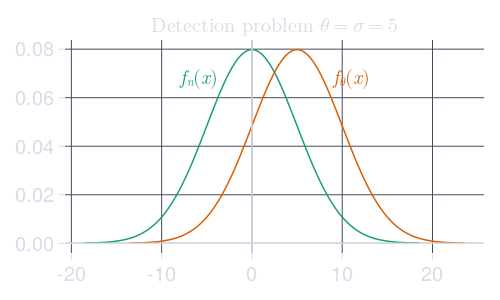

In [3]:
θ = σ = 5
fn = Normal(0,σ); fs = Normal(θ,σ)
F = Figure(backgroundcolor=:transparent, resolution=(500, 300))
ax = Axis(F[1,1], title=L"\text{Detection problem } \theta=\sigma=5")
l1 = lines!(fn); l2 = lines!(fs)
yline = vlines!(0, color = nord[5]); xline = hlines!(0, color = nord[5])
text!(-8, pdf(fn,4)*1.1, text=L"f_n(x)", color=l1.color)
text!(4+θ, pdf(fs,4+θ)*1.1, text=L"f_\theta(x)", color=l2.color)
hidespines!(ax)
save("b.pdf", F)
F

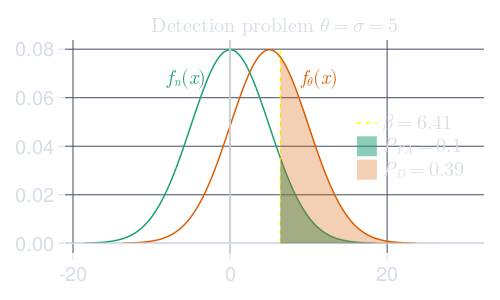

In [4]:
β = cquantile(fn, 0.1)
P_fa = ccdf(fn, β)
P_d  = ccdf(fs, β)
lines!([β, β], [0.0,pdf(fn, 0)], linestyle=:dash, color=:yellow,label=L"β=%$(printx(β,2))")
xs2 = β:0.1:xs[end]
b1 = band!(xs2, zeros(size(xs2)), pdf.(fn,xs2), color=(l1.color, 0.5), transparency=true, label=L"P_{FA}=%$(printx(P_fa,1))")
b2 = band!(xs2, zeros(size(xs2)), pdf.(fs,xs2), color=(l2.color, 0.3), transparency=true, label=L"P_{D}=%$(printx(P_d,2))")
axislegend(ax, position=:rc)
save("c.pdf", F)
F

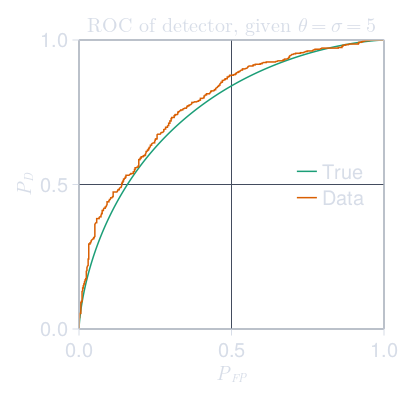

In [78]:
nData = 1000
s = θ * (randn(nData,1) .>= 0); # True data
x = s + σ * randn(size(s));

# Theoretical ROC
βs = 20:-0.01:-20
TPR_true,TFP_true = ccdf.(fs,βs), ccdf.(fn,βs)

detector = map(β -> β .< x, βs)
TPR_data = map(result -> mean(result[s .> 0.5θ]), detector)
TFP_data = map(result -> mean(result[s .< 0.5θ]), detector);

F = Figure(backgroundcolor=:transparent, resolution=(400, 400))
ax = Axis(F[1,1], title=L"\text{ROC of detector, given }\theta=\sigma=5", xlabel=L"P_{FP}", ylabel=L"P_{D}")
xlims!(0,1);ylims!(0,1)
lines!(TFP_true, TPR_true, label="True")
lines!(TFP_data, TPR_data, label="Data")
axislegend(ax, position=:rc)
F

In [116]:
nData = 1000
βs = 20:-0.01:-20

function roc_realization()
    s = θ * (randn(nData,1) .>= 0); # True data
    x = s + σ * randn(size(s));
    detector = map(β -> β .< x, βs)
    TPR_data = map(result -> mean(result[s .> 0.5θ]), detector)
    TFP_data = map(result -> mean(result[s .< 0.5θ]), detector);
    return TPR_data, TFP_data
end


roc_realization (generic function with 1 method)

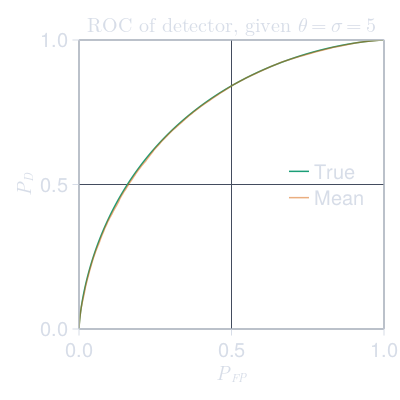

In [118]:
many_runs = [ roc_realization() for _ in 1:100 ]

TPR_many = mapreduce(run ->run[1], hcat, many_runs)
TFP_many = mapreduce(run -> run[2], hcat, many_runs)  # -> β × run

TPR_mean = mean(TPR_many, dims=2); TFP_mean = mean(TFP_many, dims=2);

F = Figure(backgroundcolor=:transparent, resolution=(400, 400))
ax = Axis(F[1,1], title=L"\text{ROC of detector, given }\theta=\sigma=5", xlabel=L"P_{FP}", ylabel=L"P_{D}")
xlims!(0,1);ylims!(0,1)
lines!(TFP_true, TPR_true, label="True")
lines!(TFP_mean[:], TPR_mean[:], label="Mean", color = (Dark2_8[2], 0.5))
axislegend(ax, position=:rc)
F

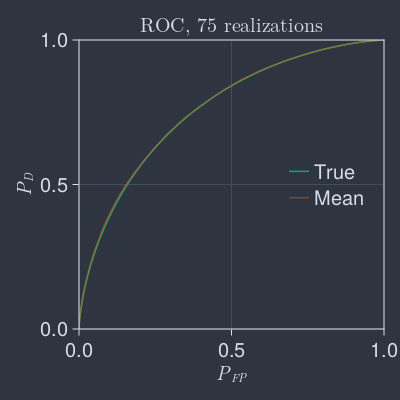

In [133]:
function step(frame=1)
    many_runs = [ roc_realization() for _ in 1:frame ]

    TPR_many = mapreduce(run ->run[1], hcat, many_runs)   # All TPR [β × run]
    TFP_many = mapreduce(run -> run[2], hcat, many_runs)  # All TFP [β × run]

    return Point2f.(mean(TFP_many, dims=2)[:],mean(TPR_many, dims=2)[:]);
end

F = Figure(backgroundcolor=nord[1],resolution=(400, 400))
ax = Axis(F[1,1], title=L"\text{ROC of detector, given }\theta=\sigma=5", xlabel=L"P_{FP}", ylabel=L"P_{D}")
xlims!(0,1);ylims!(0,1)
lines!(TFP_true, TPR_true, label="True")

points = Observable(Point2f[])

mean_line = lines!(points, label="Mean", color = (Dark2_8[2], 0.5))
axislegend(ax, position=:rc)

N_frames = 75

record(F, "test.mp4", 1:N_frames, framerate=7) do frame
    points[] = step(frame)
    ax.title = L"\text{ROC, %$(frame)/%$(N_frames) realizations}"
    notify(points)
end

F